# Анализ инструкций, сгенерированных LLM

На предыдущем шаге мы оценили текстовый корпус, полученный после парсинга страниц [сайта Донецкого Государственного университета](https://donnu.ru/), здесь же посмотрим на полученный результат и подготовим данные к формату, пригодному для дообучения LLM с помощью [LoRA](https://huggingface.co/docs/text-generation-inference/conceptual/lora)

## Импорт необходимых библиотек и модулей

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

In [2]:
import pandas as pd

In [3]:
from core.utils.data_analysis import *
from core.utils.common import init_random_seed

Для воспроизводимости экспериментов

In [4]:
init_random_seed(42)

## Загрузка имеющихся и полученных данных

In [5]:
data_path = 'data'

Загрузим полученный на [предыдущем шаге](https://github.com/EliseevVadim/TextsEstimator/blob/main/texts_estimation_analysis.ipynb) набор данных с релевантными текстами, на основе которых была проведена генерация инструкций

In [6]:
relevant_texts = pd.read_csv(f'{data_path}/input/relevant_texts.csv', index_col=0)
relevant_texts.sample(10)

,id,filename,content,size,rounded_size_kb,last_updated,already_evaluated,gemma2-9b-it,llama-3.1-70b-versatile,llama-3.3-70b-versatile,average_score
2068,2480,Физическая культура и спорт_ теория и практика,Русский,14,0,18-11-2021,True,2.0,2.0,3.0,2.333333
2379,864,Информация о направлениях и результатах научно...,Содержание\n\nИнформация о сроке действия госу...,138309,135,18-09-2024,False,5.0,5.0,5.0,5.000000
1719,2067,Редакционная политика,Редакционная политика\n\nАвторское право.\n\nС...,4836,5,27-02-2024,True,3.0,4.0,4.0,3.666667
2674,2556,Хвостова Елена Николаевна,Хвостова Елена Николаевна\n\nДолжность:\n\nста...,12131,12,07-06-2024,False,5.0,5.0,5.0,5.000000
2495,1462,Направления работы центра,ПСИХОЛОГИЧЕСКОЕ КОНСУЛЬТИРОВАНИЕ\n\nПсихологи ...,15842,15,28-04-2023,False,5.0,5.0,5.0,5.000000
1979,2385,Учебная деятельность,Торжественная церемония вручения дипломов\n\nК...,6638,6,05-12-2019,True,4.0,4.0,4.0,4.000000
564,635,Есенинский центр,В марте 2018 года ректором ДонНУ С. В. Беспало...,4913,5,29-08-2024,True,4.0,4.0,3.0,3.666667
1566,1898,Преподавательский состав,ПРОФЕССОРСКО-ПРЕПОДАВАТЕЛЬСКИЙ СОСТАВ КАФЕДРЫ\...,2005,2,14-11-2019,True,3.0,4.0,4.0,3.666667
1011,1198,Кудрейко Ирина Александровна,Кудрейко Ирина Александровна\n\nДолжность:\n\n...,7801,8,31-08-2022,True,4.0,4.0,4.0,4.000000
562,632,Еропутова Ольга Александровна,Еропутова Ольга Александровна\n\nДолжность:\n\...,9780,10,08-05-2024,True,4.0,5.0,5.0,4.666667


Также загрузим json-файл с инструкциями и информацией о файлах, на основе которых они были сгенерированы

In [7]:
generated = read_generation_log_as_frame(data_path=f'{data_path}/output/generation_log.json')
generated.sample(10)

,file_id,filename,input,output
10376,1504,Научная деятельность,Каковы результаты эколого-фаунистических монит...,Эколого-фаунистические мониторинговые исследов...
5337,809,Информация для студентов,Какие ссылки на облако доступны для преподават...,Для преподавателей кафедры национальной и реги...
14288,2090,Рецензирование статей,Каково окончательное решение о публикации стат...,Наличие положительной рецензии не является дос...
11967,1741,Першина Ксения Витальевна,Какое ученое звание имеет Першина Ксения Витал...,Першина Ксения Витальевна не имеет ученого звания
5221,800,Информация для студентов,Для чего предназначены электронные адреса и уч...,Для дистанционного обучения
4736,718,Информация для абитуриентов,Кто является ответственным за профориентационн...,Васильев Артем Сергеевич является ответственны...
11960,1740,Першина Клавдия Васильевна,Какие учебно-методические публикации имеет Пер...,Першина Клавдия Васильевна имеет следующие уче...
11913,1734,"Переводы, восстановления",Какие ограничения на количество дисциплин и пр...,Перевод обучающихся при академической разнице ...
5391,811,Информация для студентов,Когда вводится организация образовательного пр...,Организация образовательного процесса с исполь...
14762,2145,Рыбина Ольга Владимировна,Какой стаж работы у Рырина Ольга Владимировна?,Рырина Ольга Владимировна имеет общий стаж раб...


Посмотрим на число сгенерированных инструкций

In [8]:
print(f"Всего было сгенерировано инструкций: {generated.shape[0]}")

Всего было сгенерировано инструкций: 24854


## Анализ релевантных текстов и сгенерированных инструкций

Вычислим, сколько инструкций было сгенерировано по каждому файлу

In [9]:
files_with_counts = generated.groupby('file_id').agg(
    filename=pd.NamedAgg(column='filename', aggfunc='first'),
    instructions=pd.NamedAgg(column='input', aggfunc='count')
).reset_index()

files_with_counts.sample(10)

,file_id,filename,instructions
441,1424,Направления подготовки,6
258,124,Абитуриенту 2018,1
1548,2591,Чаусовский Александр Михайлович,15
1739,38,"Studia Germanica, Romanica et Comparatistica (...",9
2208,9,Cвидетельство об аккредитации в РФ,6
2083,782,Информация для студентов,7
867,1860,Практическая подготовка,12
1171,2200,Скопылатова Виктория Игоревна,10
403,139,Акаев Шамиль Муртузович,13
1127,216,Баранова Оксана Викторовна,10


Посмотрим на описательные характеристики количеств инструкций по файлам

In [10]:
files_with_counts.describe().T

,count,mean,std,min,25%,50%,75%,max
instructions,2316.0,10.725389,5.803676,0.0,8.0,11.0,13.0,115.0


Видим, что в среднем, на каждый файл пришлось по 10-11 инструкций, что достаточно хороший показатель, однако есть заметный выброс - по одному из файлов было сгенерировано `115` инструкций. Посмотрим что это за файл 

In [11]:
files_with_counts.loc[files_with_counts['instructions'].idxmax()]

file_id                       644
filename        Жизнь факультета 
instructions                  115
Name: 1948, dtype: object

При ручном просмотре файла и полученных инструкций можно сделать вывод, что они являются достаточно релевантными, а потому удалены не будут

Посмотрим на топ-10 файлов по числу сгенеированных инструкций

In [12]:
files_with_counts.sort_values(by='instructions', ascending=False).head(10)

,file_id,filename,instructions
1948,644,Жизнь факультета,115
1673,287,Вакансии,100
2143,839,Информация для студентов,79
1298,2322,Темы исследовательских работ,49
2115,811,Информация для студентов,49
1346,2372,Учебная деятельность,41
819,1810,Поступление,41
818,1809,Поступление,41
47,1040,Кафедры экономического факультета,37
2071,770,Информация для студентов,36


Как видно, явных выбросов в распределении числа инструкций нет, инструкции по первым трем файлам являюся релевантными, поэтому не будем исключать из наборов данных эти файлы и соответствующие им инструкции

## Повторная генерация для файлов с малым числом сгенерированных инструкций

Посмотрим, сколько файлов содержит определенное число инструкций. Так мы сможем определить файлы, для которых было сгенеировано малое число инструкций и отправить их на повторную генерацию. Повторная генерация будет осуществлена как и исходная, но с более низкими значениями для `temperature` и `top_p`, а также с другим `seed`

In [13]:
instructions_counts = files_with_counts.groupby(by='instructions').agg(
    files=pd.NamedAgg(column='filename', aggfunc='count')
).reset_index()

instructions_counts

,instructions,files
0,0,14
1,1,62
2,2,1
3,3,14
4,4,39
5,5,155
6,6,127
7,7,154
8,8,140
9,9,180


Добавим столбец с куммулятивной суммой, который покажет нам, для скольки файлов нужно сделать повторную генерацию инструкций, если мы будем считать "проблемными" файлы, в которых меньше N инструкций

In [14]:
instructions_counts['cummulative'] = instructions_counts['files'].cumsum()
instructions_counts

,instructions,files,cummulative
0,0,14,14
1,1,62,76
2,2,1,77
3,3,14,91
4,4,39,130
5,5,155,285
6,6,127,412
7,7,154,566
8,8,140,706
9,9,180,886


Возьмем в качестве порогового значения число инструкций `3`, таким образом мы отправим на повторную генерацию 91 файл

In [15]:
threshold = 3

Выделим эти "проблемные" файлы

In [16]:
problematic_files = files_with_counts[files_with_counts['instructions'] <= threshold]
problematic_files.sample(10)

,file_id,filename,instructions
2048,742,Информация для преподавателей,1
1494,2542,Финохин Виктор Иванович,1
1184,2213,Советы психолога,0
1716,359,Вильдгрубе Светлана Александровна,1
2125,821,Информация для студентов,3
15,1011,Кафедра теоретической физики и нанотехнологий,1
1750,39,"To the authors concern _ Journal of History, P...",1
271,1256,Лицей (lyceum) _ Page 26,3
2134,83,ud _ Page 49,1
1809,450,Грудева Елена Германовна,1


Объединим выделенные файлы и соответствующие им ранее сгенерированные инструкции

In [17]:
problematic_ids = problematic_files['file_id'].tolist()
problematic_instructions = generated[generated['file_id'].isin(problematic_ids)]
problematic_instructions

,file_id,filename,input,output
227,24,Reviewing articles,"Каков порядок направления, рассмотрения и публ...",Статьи принимаются к рассмотрению при условии ...
228,25,Rules for authors,Какие направления статьи принимаются в сборнике?,Статьи принимаются под следующими заголовками:...
294,39,"To the authors concern _ Journal of History, P...",Какие требования предъявляются к статьям для п...,Статьи должны соответствовать определенным фор...
749,83,ud _ Page 49,Кто такой Валерий Имонтович Амолин?,Валерий Имонтович Амолин является преподавател...
1370,176,Артамонова Инесса Михайловна,None,None
...,...,...,...,...
23209,1824,Правила для авторов,Какие требования предъявляются к авторам статей?,Авторы научных статей несут персональную ответ...
23785,2137,Руководство. Педагогический (научно-педагогиче...,None,None
23795,2153,Савчук Светлана Михайловна,None,None
24049,2213,Советы психолога,None,None


Запишем полученные данные в csv файл и проведем повторную генерацию

In [18]:
save_frame_as_instructions_json(data=problematic_instructions, 
                                id_column='file_id', 
                                name_column='filename', 
                                path=f'{data_path}/input/problem_instructions.json'
                               )

## Результаты повторной генерации инструкций

Финальный запуск процедуры повторной генерации инструкций выглядел следующим образом:

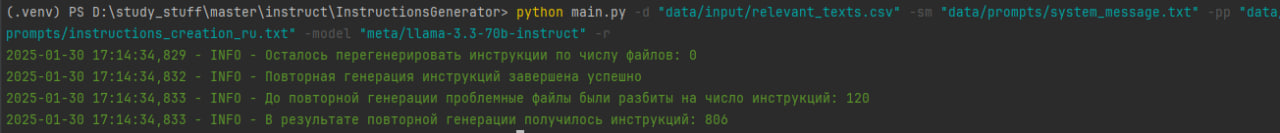

Мы видим, что из `120` инструкций, соответствующих проблемным файлам, мы получили `806` (новые инструкции добавлялись к уже существующим)

Посмотрим на итоговое количество инструкций в лог-файле

In [19]:
finally_generated = read_generation_log_as_frame(data_path=f'{data_path}/output/generation_log.json')
print(f"Итого было получено инструкций: {finally_generated.shape[0]}")

Итого было получено инструкций: 25633


Такое число инструкций является хорошим показателем. Для сравнения, датасет [self-instruct](https://huggingface.co/datasets/yizhongw/self_instruct) содержит 52k инструкций, однако в нашем случае предметная область ограничивается деятельностью одного университета, в то время как Self-Instruct охватывает разные области (код, математика, рассуждения, повседневные задачи и т. д.)